# IMPORT AND LOAD DATA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# make plots look nicer
sns.set(style="whitegrid", context="notebook")
%matplotlib inline

In [3]:
np.random.seed(42)
n = 300
df = pd.DataFrame({
    "CustomerID": np.arange(1, n+1),
    "Age": np.random.normal(38, 12, n).clip(18, 80).astype(int),
    "Gender": np.random.choice(["Male","Female"], n),
    "AnnualIncome": np.random.normal(60000, 25000, n).clip(8000, 200000).astype(int),
    "TenureMonths": np.random.exponential(scale=24, size=n).astype(int).clip(0,240),
    "NumPurchases": np.random.poisson(lam=20, size=n).clip(0,200),
    "AvgPurchaseValue": np.round(np.random.normal(80, 40, n).clip(5,200),2),
})
df["TotalSpent"] = (df["NumPurchases"] * df["AvgPurchaseValue"]).astype(int)
df["RecencyDays"] = np.random.exponential(scale=60, size=n).astype(int).clip(1,365)
df["SpendingScore"] = np.round(np.interp(df["TotalSpent"], (df["TotalSpent"].min(), df["TotalSpent"].max()), (1,100))).astype(int)
df.head()

,CustomerID,Age,Gender,AnnualIncome,TenureMonths,NumPurchases,AvgPurchaseValue,TotalSpent,RecencyDays,SpendingScore
0,1,43,Male,48748,21,19,128.84,2447,83,47
1,2,36,Female,75571,7,15,103.28,1549,4,29
2,3,45,Female,33309,23,23,70.94,1631,5,31
3,4,56,Male,56440,12,12,41.62,499,26,9
4,5,35,Male,63007,19,22,65.11,1432,170,27


# DATA CHECK AND EDA

In [4]:
print(df.info())
print(df.describe().T)    # summary stats for numeric columns
print("Missing values per column:")
print(df.isna().sum())

# If you want to see counts of categorical columns:
for col in df.select_dtypes(include=['object','category']).columns:
    print("\nValue counts for", col)
    print(df[col].value_counts().head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        300 non-null    int64  
 1   Age               300 non-null    int64  
 2   Gender            300 non-null    object 
 3   AnnualIncome      300 non-null    int64  
 4   TenureMonths      300 non-null    int64  
 5   NumPurchases      300 non-null    int32  
 6   AvgPurchaseValue  300 non-null    float64
 7   TotalSpent        300 non-null    int64  
 8   RecencyDays       300 non-null    int64  
 9   SpendingScore     300 non-null    int64  
dtypes: float64(1), int32(1), int64(7), object(1)
memory usage: 22.4+ KB
None
                  count          mean           std     min       25%  \
CustomerID        300.0    150.500000     86.746758     1.0     75.75   
Age               300.0     37.646667     11.307284    18.0     29.00   
AnnualIncome      300.0  58979.980

# CHOOSING FEATURES TO CLUSTER

In [6]:
features = ["Age","Gender","AnnualIncome","TenureMonths","NumPurchases",
            "AvgPurchaseValue","TotalSpent","RecencyDays","SpendingScore"]

# Ensure chosen features exist
for f in features:
    if f not in df.columns:
        print("Warning: feature not in dataset:", f)


# PREPROCESSING : ENCODE CATEGORICAL + SCALE NUMERIC

In [7]:
df_proc = df.copy()

# 2) Encode Gender (if present)
if "Gender" in df_proc.columns:
    le = LabelEncoder()
    df_proc["GenderEncoded"] = le.fit_transform(df_proc["Gender"].astype(str))
    # replace "Gender" in features with "GenderEncoded"
    features = ["GenderEncoded" if x=="Gender" else x for x in features]

# 3) Keep only numeric columns we will use
X = df_proc[features].astype(float)

# 4) Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature shape:", X_scaled.shape)

Scaled feature shape: (300, 9)


# FINDING GOOD NUMBER OF CLUSTERS K (ELBOW + SILHOUTEE)

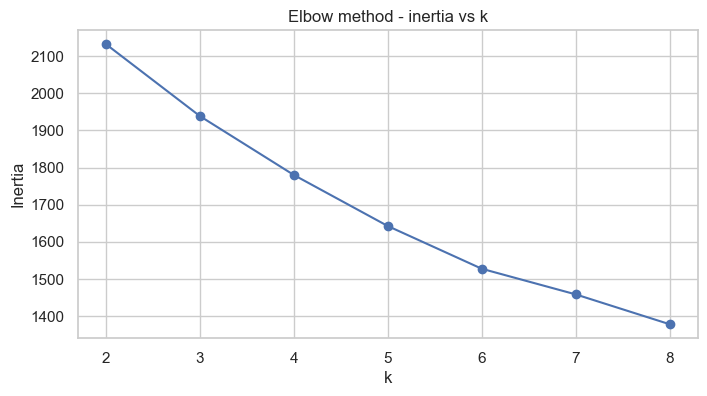

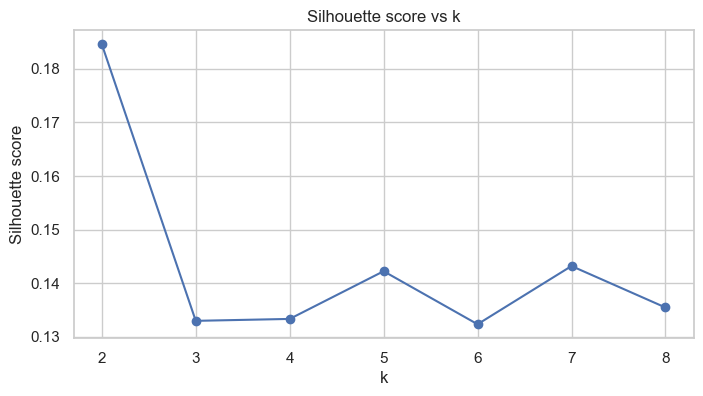

Recommended k by silhouette score: 2


In [8]:
inertia = []
sil_scores = []
K_range = range(2,9)   # 2..8

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, labels))

# Plot inertia (elbow)
plt.figure(figsize=(8,4))
plt.plot(list(K_range), inertia, marker='o')
plt.title("Elbow method - inertia vs k")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(list(K_range), sil_scores, marker='o')
plt.title("Silhouette score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.show()

# Print best k by silhouette
best_k = K_range[np.argmax(sil_scores)]
print("Recommended k by silhouette score:", best_k)

# FIT K MEANS WITH CHOSEN K AND LABEL CUSTOMERS

In [9]:
k = int(best_k)   # or set k = 3, etc.

kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df["Cluster"] = labels   # attach to original df for easy analysis

# Save to CSV if you want
df.to_csv("customers_with_clusters.csv", index=False)
print("Saved customers_with_clusters.csv")

Saved customers_with_clusters.csv


# INSPECT CLUSTER SIZEZ AND SUMMARY STATISTICS

In [10]:
print("Cluster sizes:")
print(df["Cluster"].value_counts().sort_index())

# Mean values per cluster for features
cluster_summary = df.groupby("Cluster").agg({
    "Age":"mean",
    "AnnualIncome":"mean",
    "TenureMonths":"mean",
    "NumPurchases":"mean",
    "AvgPurchaseValue":"mean",
    "TotalSpent":"mean",
    "RecencyDays":"mean",
    "SpendingScore":"mean",
    "CustomerID":"count"
}).rename(columns={"CustomerID":"Count"})

cluster_summary = cluster_summary.round(1)
cluster_summary

Cluster sizes:
Cluster
0    128
1    172
Name: count, dtype: int64


,Age,AnnualIncome,TenureMonths,NumPurchases,AvgPurchaseValue,TotalSpent,RecencyDays,SpendingScore,Count
Cluster,,,,,,,,,
0,38.2,58424.0,26.5,21.9,111.4,2382.7,43.4,45.6,128
1,37.2,59393.7,25.0,18.4,58.9,1032.4,71.7,19.5,172


# VISUALIZE CLUSTERS PCA TO 2D + BOXPLOTS

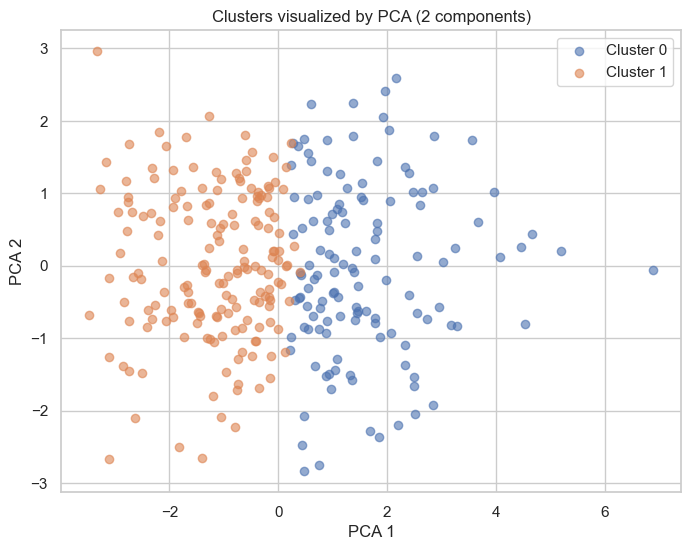

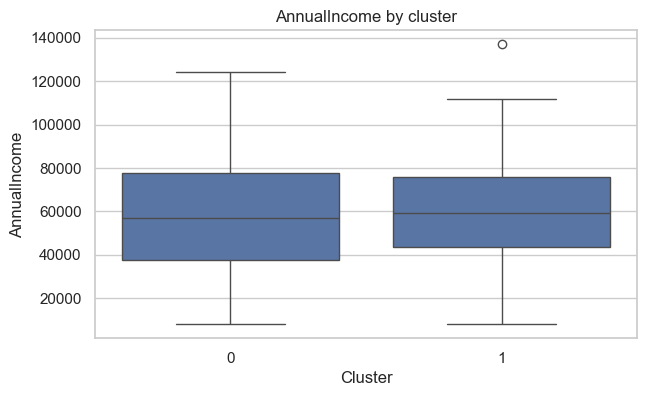

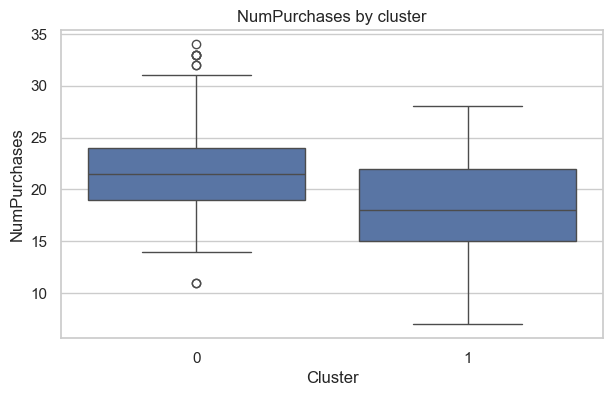

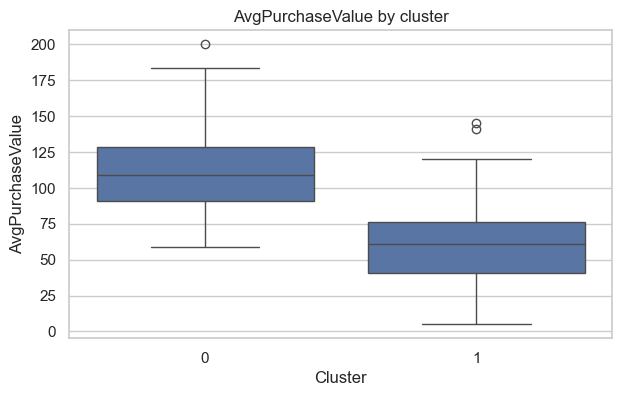

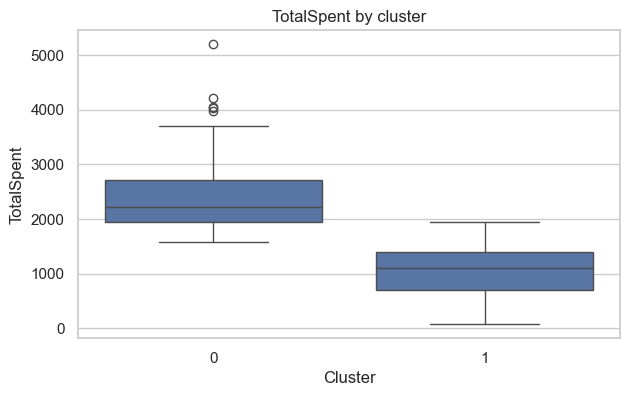

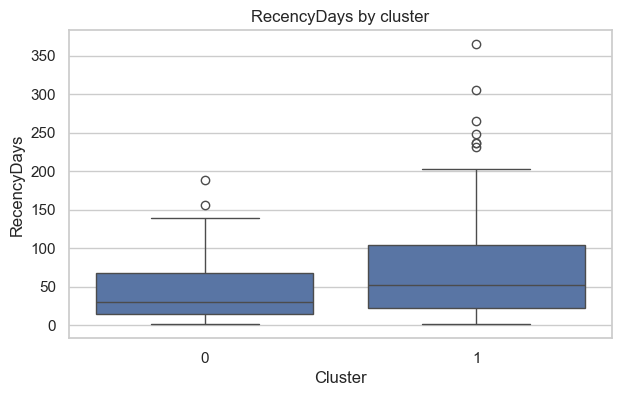

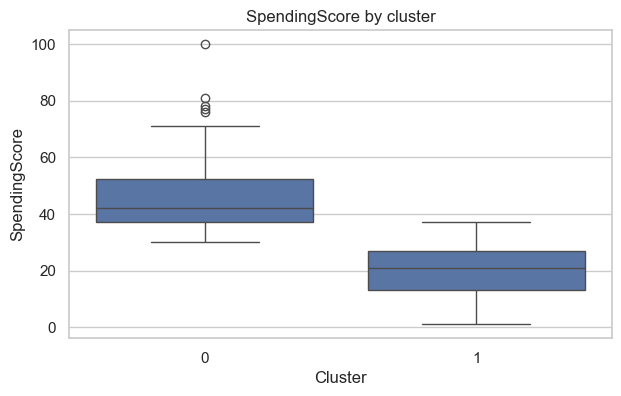

In [12]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for c in sorted(df["Cluster"].unique()):
    mask = df["Cluster"]==c
    plt.scatter(X_pca[mask,0], X_pca[mask,1], label=f"Cluster {c}", alpha=0.6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters visualized by PCA (2 components)")
plt.legend()
plt.show()

# Boxplots for key numeric features grouped by cluster
plot_features = ["AnnualIncome","NumPurchases","AvgPurchaseValue","TotalSpent","RecencyDays","SpendingScore"]
for feat in plot_features:
    plt.figure(figsize=(7,4))
    sns.boxplot(x="Cluster", y=feat, data=df)
    plt.title(f"{feat} by cluster")
    plt.show()

In [ ]:
# LOOK AT CLUSTERS

In [13]:
centers_scaled = kmeans.cluster_centers_
# build a temporary array with the same column order as X
centers_orig = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_orig, columns=features)
centers_df["Cluster"] = range(len(centers_df))
# reorder columns so Cluster is first
cols = ["Cluster"] + [c for c in centers_df.columns if c!="Cluster"]
centers_df = centers_df[cols]
centers_df.round(1)

,Cluster,Age,GenderEncoded,AnnualIncome,TenureMonths,NumPurchases,AvgPurchaseValue,TotalSpent,RecencyDays,SpendingScore
0,0,38.2,0.5,58424.0,26.5,21.9,111.4,2382.7,43.4,45.6
1,1,37.2,0.6,59393.7,25.0,18.4,58.9,1032.4,71.7,19.5


In [14]:
df.to_csv("customers_with_clusters.csv", index=False)
cluster_summary.reset_index().to_csv("cluster_summary.csv", index=False)
centers_df.to_csv("cluster_centers.csv", index=False)
print("Saved: customers_with_clusters.csv, cluster_summary.csv, cluster_centers.csv")

Saved: customers_with_clusters.csv, cluster_summary.csv, cluster_centers.csv
